# Loan Approval Prediction Project
Team: Shailja Somani, Verity Pierson, & Mirna Philip\
Dataset Used: Demographic and loan information for select loan applicants, along with if they were approved or not. Retreived from Kaggle at: https://www.kaggle.com/datasets/mirzahasnine/loan-data-set?resource=download\ \
Project Github: https://github.com/shailja-somani-0/loan-approval-pred

## Import and Clean Dataset

In [85]:
# Import packages necessary
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.naive_bayes import MultinomialNB
import statsmodels.api as sm
import statsmodels.tools.tools as stattools

In [83]:
# Check working directory if necessary - commented out as not necessary
#os.getcwd()

In [3]:
# Importing the csv file 
loan_df = pd.read_csv('loan_train.csv', header=0, sep=',')
loan_df.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [4]:
# Checking to see what the data looks like
loan_df.describe()

,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History
count,6.140000e+02,6.140000e+02,6.140000e+02,600.00000,564.000000
mean,5.403459e+05,1.621246e+05,1.414104e+07,342.00000,0.842199
std,6.109042e+05,2.926248e+05,8.815682e+06,65.12041,0.364878
min,1.500000e+04,0.000000e+00,0.000000e+00,12.00000,0.000000
25%,2.877500e+05,0.000000e+00,9.800000e+06,360.00000,1.000000
50%,3.812500e+05,1.188500e+05,1.250000e+07,360.00000,1.000000
75%,5.795000e+05,2.297250e+05,1.647500e+07,360.00000,1.000000
max,8.100000e+06,4.166700e+06,7.000000e+07,480.00000,1.000000


In [5]:
# Drop all rows with null values
loan_df = loan_df.dropna()
loan_df.shape

(499, 12)

In [23]:
# One-hot encode Area, which has 3 possible answers
loan_encoded = pd.get_dummies(loan_df, columns=['Area'], drop_first=False)

# Encode binary features & target variable to 1 and 0 - use drop_first to have only one column per variable
loan_encoded = pd.get_dummies(loan_encoded, columns=['Gender', 'Married', 'Education', 'Self_Employed','Status'], drop_first=True)

# Convert 3+ in Dependents to just 3 so it's numerical
loan_encoded['Dependents'] = loan_encoded['Dependents'].replace('3+', '3')
loan_encoded['Dependents'] = loan_encoded['Dependents'].astype(int)

loan_encoded.head()

,Dependents,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area_Rural,Area_Semiurban,Area_Urban,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Status_Y
0,0,584900,0.0,15000000,360.0,1.0,0,0,1,1,0,0,0,1
1,1,458300,150800.0,12800000,360.0,1.0,1,0,0,1,1,0,0,0
2,0,300000,0.0,6600000,360.0,1.0,0,0,1,1,1,0,1,1
3,0,258300,235800.0,12000000,360.0,1.0,0,0,1,1,1,1,0,1
4,0,600000,0.0,14100000,360.0,1.0,0,0,1,1,0,0,0,1


In [44]:
# Split data into X & y and train and test datasets
X = loan_encoded.drop('Status_Y', axis=1)
y = loan_encoded[['Status_Y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=38)

# print the shapes of the resulting splits
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (349, 13)
X_test shape: (150, 13)
y_train shape: (349, 1)
y_test shape: (150, 1)


## EDA

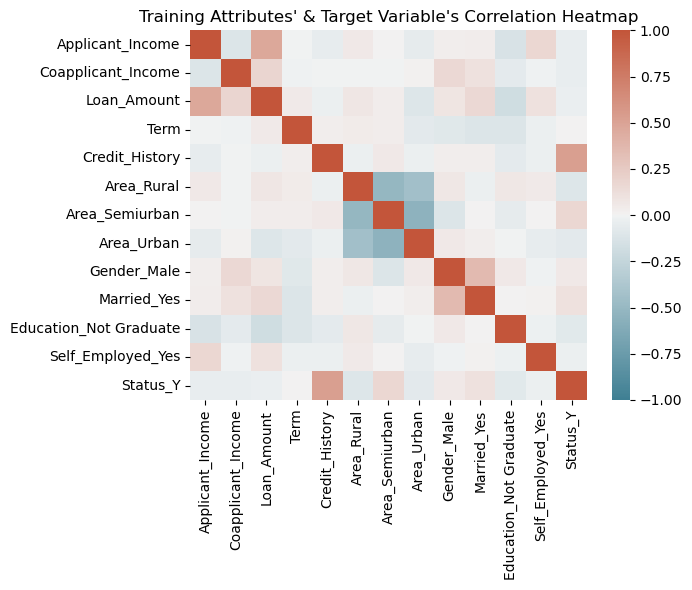

In [8]:
# Create a heatmap to show correlations between all training attributes & target variable (status)
# Get the correlation matrix 
correlation_matrix = loan_encoded.corr()

# create heatmap, set hues for negative, positive areas of map and saturation amount.
# create heatmap given: dataset, value range to anchor map with (-1 and 1), colormap name set above, set title
red_blue = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(correlation_matrix, vmin = -1, vmax = 1, cmap=red_blue).set(title="Training Attributes' & Target Variable's Correlation Heatmap")
plt.show()

In [11]:
loan_encoded['Gender_Male'].value_counts()

1    411
0     88
Name: Gender_Male, dtype: int64

In [12]:
df = loan_encoded.rename(columns={'Gender_Male': 'Gender', 'Married_Yes': 'Married', 'Education_Not Graduate': 'Education', 'Self_Employed_Yes': 'Self_Employed', 'Status_Y': "Status"}, inplace=True)

In [13]:
loan_encoded.head()

,Dependents,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area_Rural,Area_Semiurban,Area_Urban,Gender,Married,Education,Self_Employed,Status
0,0,584900,0.0,15000000,360.0,1.0,0,0,1,1,0,0,0,1
1,1,458300,150800.0,12800000,360.0,1.0,1,0,0,1,1,0,0,0
2,0,300000,0.0,6600000,360.0,1.0,0,0,1,1,1,0,1,1
3,0,258300,235800.0,12000000,360.0,1.0,0,0,1,1,1,1,0,1
4,0,600000,0.0,14100000,360.0,1.0,0,0,1,1,0,0,0,1


In [20]:
crosstab_01 = pd.crosstab(loan_encoded['Gender'], loan_encoded['Credit_History'])

<AxesSubplot:xlabel='Gender'>

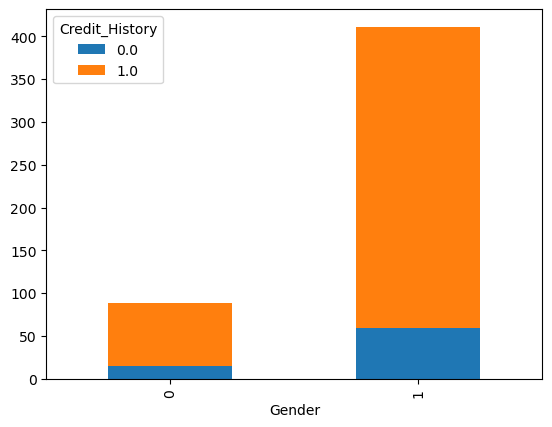

In [21]:
crosstab_01.plot(kind='bar', stacked = True)

In [25]:
crosstab_02 = pd.crosstab(loan_encoded['Gender'], loan_encoded['Status'])

<AxesSubplot:xlabel='Gender'>

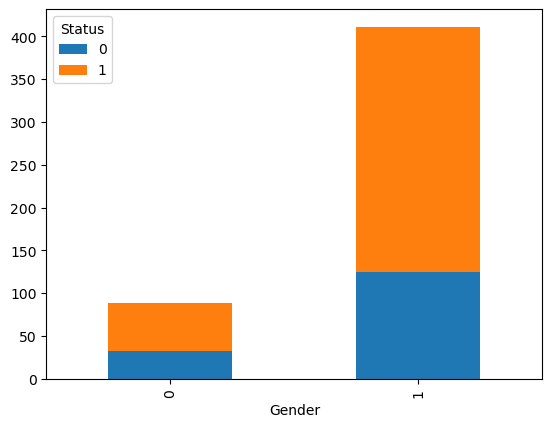

In [26]:
crosstab_02.plot(kind='bar', stacked = True)

In [27]:
crosstab_03 = pd.crosstab(loan_encoded['Education'], loan_encoded['Status'])

<AxesSubplot:xlabel='Education'>

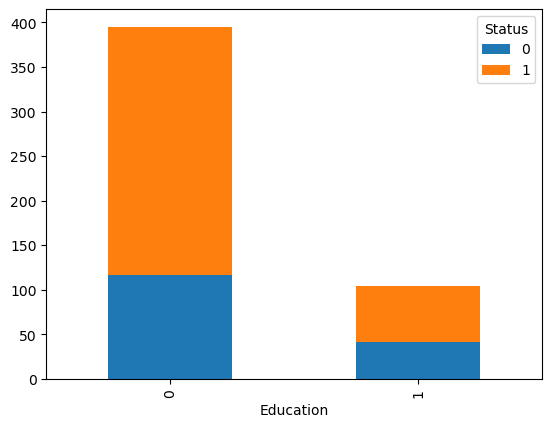

In [28]:
crosstab_03.plot(kind= "bar", stacked = True)

In [42]:
## Review the Original Dataset


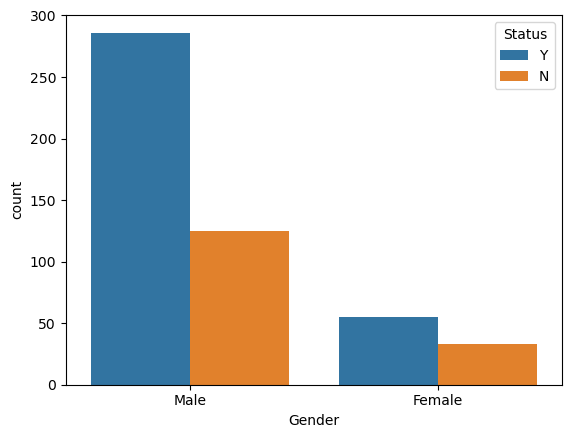

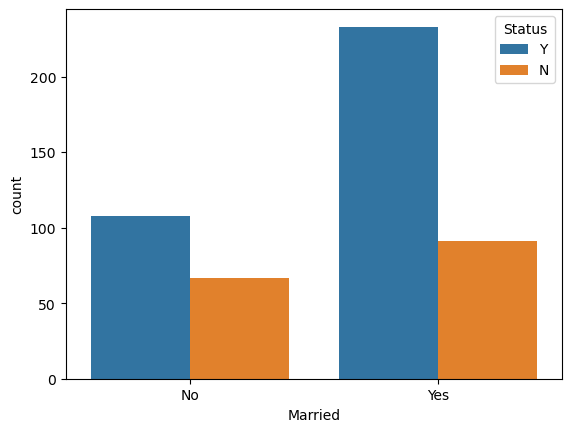

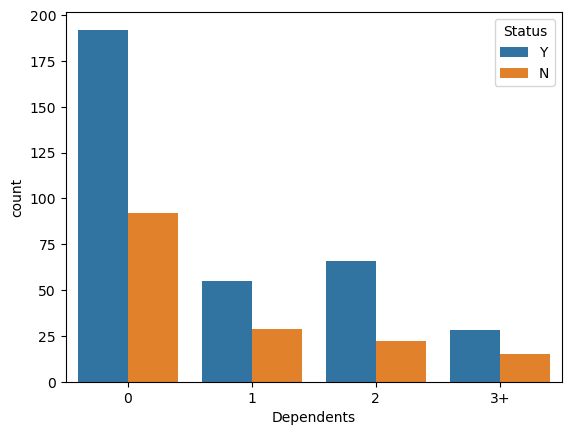

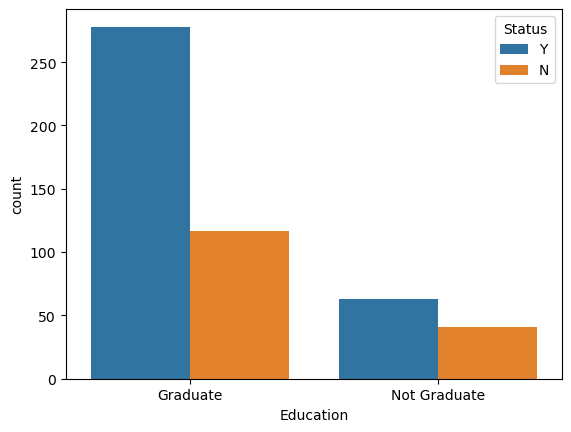

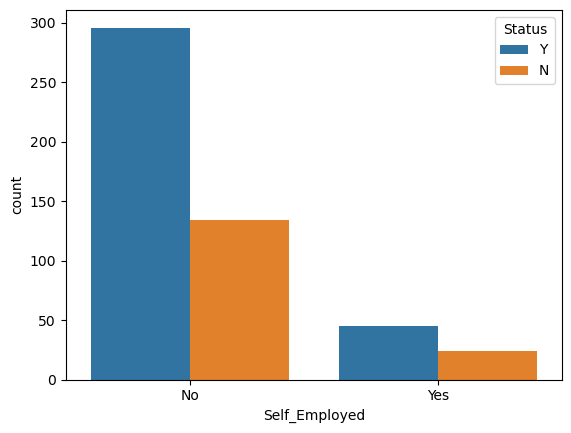

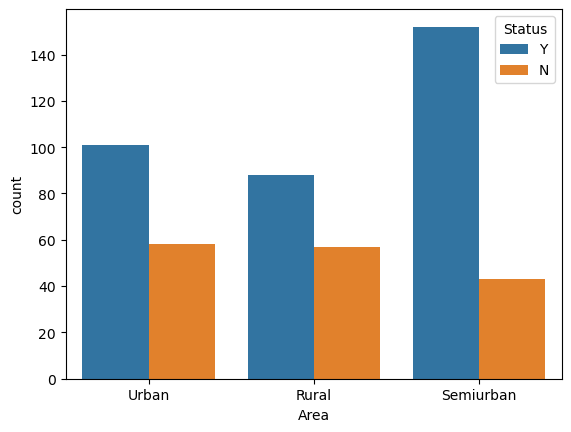

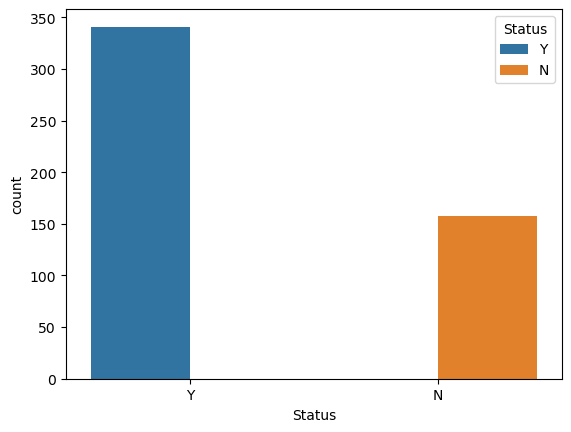

In [44]:
numeric = []
for i in loan_df.columns:
    if loan_df[i].dtypes =='O':
        sns.countplot(loan_df, x=i, hue='Status')
        plt.show()
        #else: numeric.append(i)

In [49]:
categorical_columns = [loan_df[i].name for i in loan_df.columns if loan_df
                      [i].dtype=='object']

for i in loan_df.columns:
    if i in categorical_columns:
        print(loan_df[i].value_counts())

Male      411
Female     88
Name: Gender, dtype: int64
Yes    324
No     175
Name: Married, dtype: int64
0     284
2      88
1      84
3+     43
Name: Dependents, dtype: int64
Graduate        395
Not Graduate    104
Name: Education, dtype: int64
No     430
Yes     69
Name: Self_Employed, dtype: int64
Semiurban    195
Urban        159
Rural        145
Name: Area, dtype: int64
Y    341
N    158
Name: Status, dtype: int64


In [50]:
#categorical variable % rates in original data
for i in loan_df.columns:
    if i in categorical_columns:
        print((loan_df[i].value_counts())/len(loan_df)*100)

Male      82.364729
Female    17.635271
Name: Gender, dtype: float64
Yes    64.92986
No     35.07014
Name: Married, dtype: float64
0     56.913828
2     17.635271
1     16.833667
3+     8.617234
Name: Dependents, dtype: float64
Graduate        79.158317
Not Graduate    20.841683
Name: Education, dtype: float64
No     86.172345
Yes    13.827655
Name: Self_Employed, dtype: float64
Semiurban    39.078156
Urban        31.863727
Rural        29.058116
Name: Area, dtype: float64
Y    68.336673
N    31.663327
Name: Status, dtype: float64


In [51]:
# categorical variables % rates in cleaned data
for i in loan_encoded.columns:
    if i in categorical_columns:
        print((loan_encoded[i].value_counts())/len(loan_encoded)*100)
    

0     56.913828
2     17.635271
1     16.833667
3+     8.617234
Name: Dependents, dtype: float64
1    82.364729
0    17.635271
Name: Gender, dtype: float64
1    64.92986
0    35.07014
Name: Married, dtype: float64
0    79.158317
1    20.841683
Name: Education, dtype: float64
0    86.172345
1    13.827655
Name: Self_Employed, dtype: float64
1    68.336673
0    31.663327
Name: Status, dtype: float64


In [56]:
loan_encoded.groupby(['Status']).agg('mean')

,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area_Rural,Area_Semiurban,Area_Urban,Gender,Married,Education,Self_Employed
Status,,,,,,,,,,,,
0,570362.025316,172811.392405,1.436709e+07,341.620253,0.575949,0.360759,0.272152,0.367089,0.791139,0.575949,0.259494,0.151899
1,516585.337243,149234.287387,1.376041e+07,342.193548,0.979472,0.258065,0.445748,0.296188,0.838710,0.683284,0.184751,0.131965


In [57]:
#Calculating the average income per gender
loan_encoded.pivot_table(index=['Gender', 'Status'], values='Applicant_Income', aggfunc=['mean', 'min', 'max'])

mean              min              max
              Applicant_Income Applicant_Income Applicant_Income
Gender Status                                                   
0      0         422451.515152           137800          1150000
       1         540310.909091            64500          1948400
1      0         609410.400000            15000          8100000
       1         512022.727273           102500          3999900

In [58]:
loan_encoded.pivot_table(index=['Gender', 'Status'], values='Loan_Amount', aggfunc=['mean', 'min', 'max'])

mean         min         max
                Loan_Amount Loan_Amount Loan_Amount
Gender Status                                      
0      0       1.189394e+07           0    28600000
       1       1.283091e+07           0    60000000
1      0       1.502000e+07           0    57000000
       1       1.393916e+07           0    60000000

<AxesSubplot:xlabel='Loan_Amount', ylabel='Applicant_Income'>

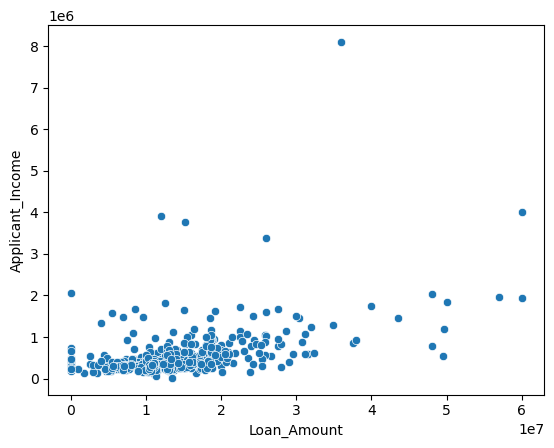

In [64]:
#Using a Scatterplot to show the loan Amount based on the Applicant's income level
sns.scatterplot(x=loan_encoded.Loan_Amount, y=loan_encoded.Applicant_Income)

<AxesSubplot:xlabel='Education', ylabel='Applicant_Income'>

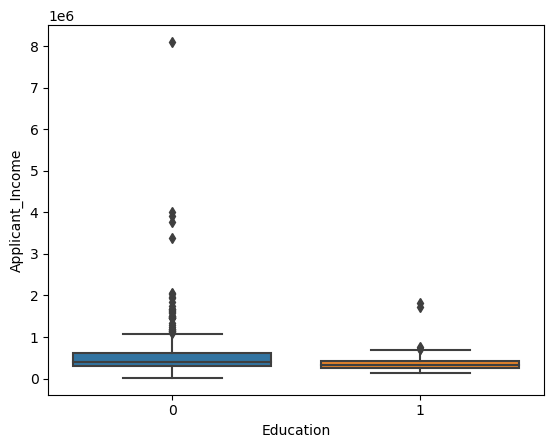

In [65]:
sns.boxplot(data=loan_encoded, x='Education', y='Applicant_Income')

<AxesSubplot:xlabel='Dependents', ylabel='Loan_Amount'>

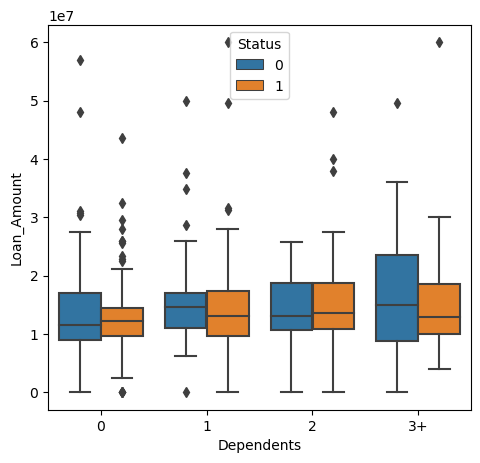

In [68]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.boxplot(data=loan_encoded, x='Dependents', y='Loan_Amount', hue='Status')

<AxesSubplot:xlabel='Dependents', ylabel='Applicant_Income'>

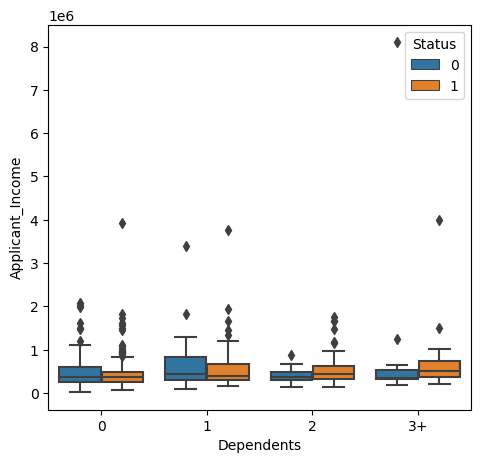

In [69]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.boxplot(data=loan_encoded, x='Dependents', y='Applicant_Income', hue='Status')

<AxesSubplot:xlabel='Dependents', ylabel='Loan_Amount'>

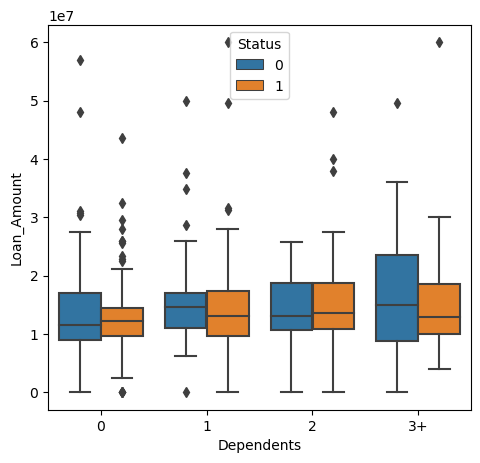

In [70]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.boxplot(data=loan_encoded, x='Dependents', y='Loan_Amount', hue='Status')

<AxesSubplot:xlabel='Self_Employed', ylabel='Applicant_Income'>

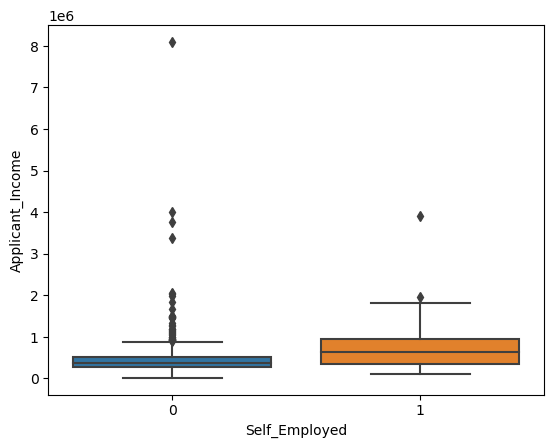

In [71]:
sns.boxplot(data=loan_encoded, x='Self_Employed', y='Applicant_Income')

## Modeling

In [58]:
# Get labels for which class comes first in predictor class
pd.unique(y_train['Status_Y'])

array([0, 1], dtype=uint8)

### Linear Regression

In [76]:
X_train_lr = sm.add_constant(X_train)
X_test_lr = sm.add_constant(X_test)

In [78]:
# Fit the linear regression model
model = sm.OLS(y_train, X_train_lr).fit()
# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Status_Y   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     12.40
Date:                Wed, 05 Apr 2023   Prob (F-statistic):           6.34e-21
Time:                        10:49:08   Log-Likelihood:                -165.37
No. Observations:                 349   AIC:                             356.7
Df Residuals:                     336   BIC:                             406.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [89]:
# Predict & get results for X_test
y_pred_lr = model.predict(X_test_lr)

print("Linear Regression MODEL:")
cm = confusion_matrix(y_test, y_pred_lr.round()) # We must round here because we get the predicted probability, not the actual class
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = model.predict(X_test_lr)
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

Linear Regression MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            20            26     46
Actual: 1             1           103    104
Total                21           129    150

Accuracy: 0.820
Sensitivity (Recall): 0.990
Specificity: 0.435
AUC score: 0.7660953177257526


### CART

In [39]:
# Fit a decision tree classifier to the training data
cart01 = DecisionTreeClassifier(criterion='gini').fit(X_train, y_train)

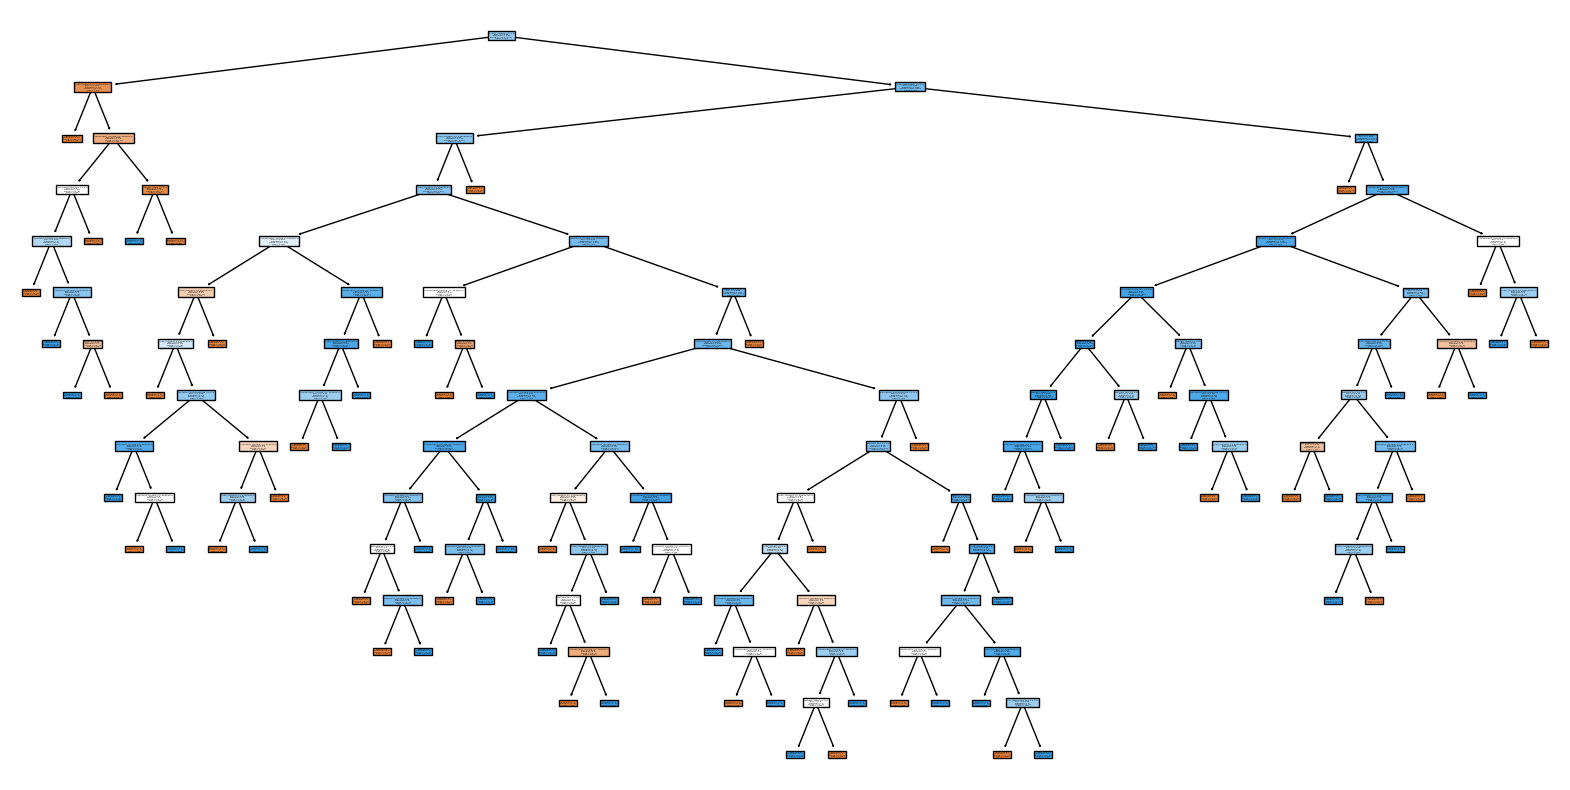

In [40]:
# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(cart01, feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True)
plt.show()

In [70]:
# Predict & get results for X_test
y_pred_cart = cart01.predict(X_test)

print("CART MODEL:")
cm = confusion_matrix(y_test, y_pred_cart)
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = cart01.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

CART MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            26            20     46
Actual: 1            23            81    104
Total                49           101    150

Accuracy: 0.713
Sensitivity (Recall): 0.779
Specificity: 0.565
AUC score: 0.6720317725752509


#### Try with fewer variables & max_leaf_nodes = 5 for better visualization & to compare metrics

In [62]:
X_train_short = X_train[['Applicant_Income', 'Credit_History', 'Loan_Amount']]
X_test_short = X_test[['Applicant_Income', 'Credit_History', 'Loan_Amount']]

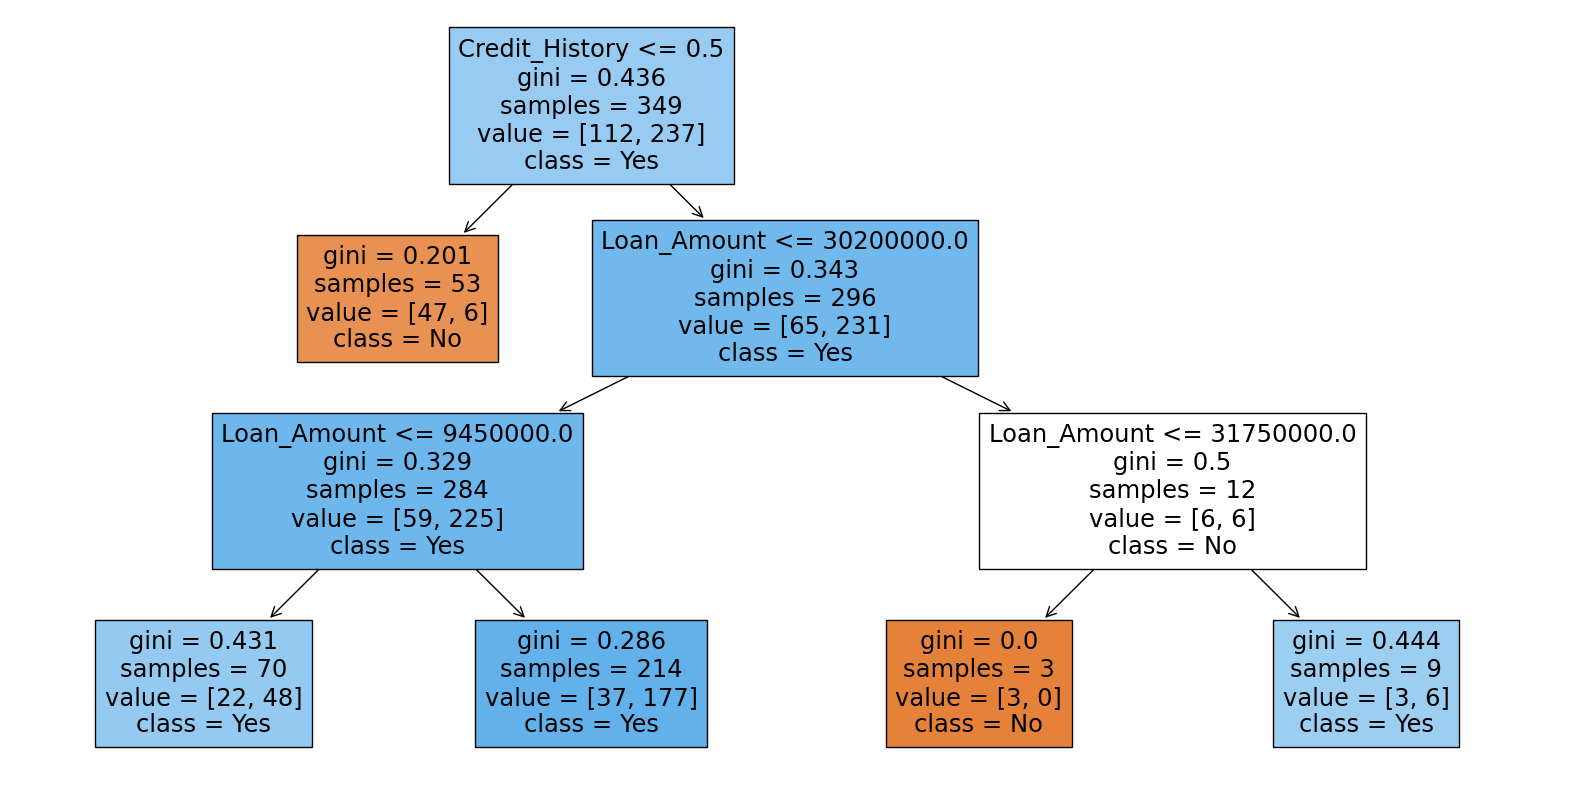

In [64]:
# Fit a decision tree classifier to the training data
cart02 = DecisionTreeClassifier(criterion='gini', max_leaf_nodes=5).fit(X_train_short, y_train)

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(cart02, feature_names=X_train_short.columns, class_names=['No', 'Yes'], filled=True)
plt.show()

In [72]:
# Predict & get results for X_test
y_pred_cart_2 = cart02.predict(X_test_short)

print("CART MODEL:")
cm = confusion_matrix(y_test, y_pred_cart_2)
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = cart02.predict_proba(X_test_short)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

CART MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            20            26     46
Actual: 1             3           101    104
Total                23           127    150

Accuracy: 0.807
Sensitivity (Recall): 0.971
Specificity: 0.435
AUC score: 0.7167642140468227


### C5.0

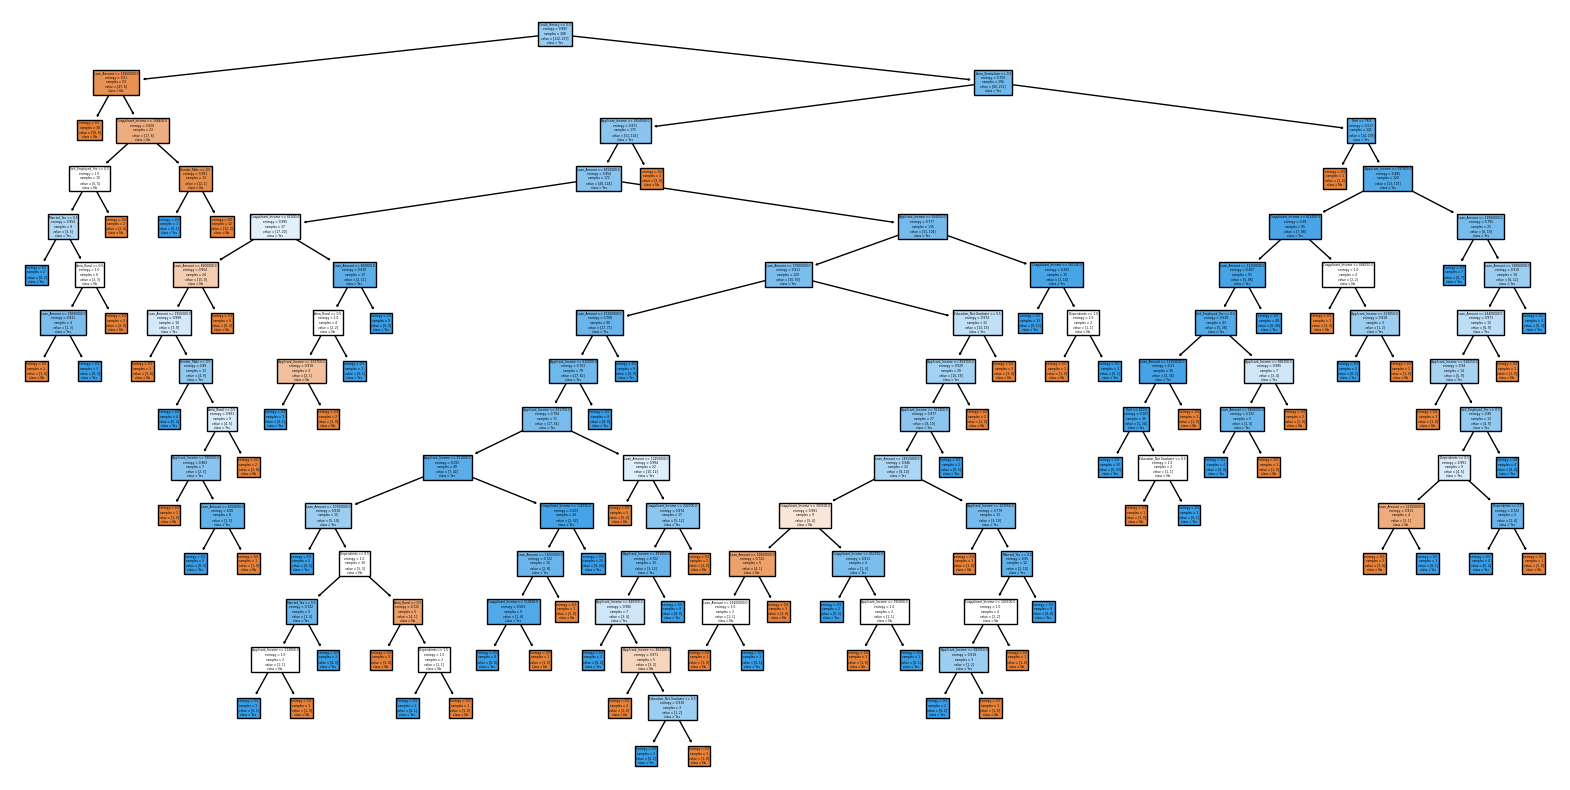

In [51]:
# Train on training dataset
c50_01 = DecisionTreeClassifier(criterion="entropy").fit(X_train,y_train)

#Visualize the decision tree using the plot_tree function:
plt.figure(figsize=(20,10))
plot_tree(c50_01, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.show()

In [73]:
# Predict & get results for X_test
y_pred_c50 = c50_01.predict(X_test)

print("C5.0 MODEL:")
cm = confusion_matrix(y_test, y_pred_c50)
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = c50_01.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

C5.0 MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            23            23     46
Actual: 1            23            81    104
Total                46           104    150

Accuracy: 0.693
Sensitivity (Recall): 0.779
Specificity: 0.500
AUC score: 0.6394230769230769


### Random Forest

/var/folders/rq/tgl8p9x96vl4gjdp366mpjv00000gn/T/ipykernel_75543/3005133104.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(n_estimators=100, criterion='gini').fit(X_train, y_train)


[Text(0.3248456790123457, 0.9642857142857143, 'Gender_Male <= 0.5\ngini = 0.43\nsamples = 223\nvalue = [109, 240]\nclass = Yes'),
 Text(0.1419753086419753, 0.8928571428571429, 'Area_Semiurban <= 0.5\ngini = 0.495\nsamples = 37\nvalue = [28, 34]\nclass = Yes'),
 Text(0.08641975308641975, 0.8214285714285714, 'Area_Rural <= 0.5\ngini = 0.483\nsamples = 17\nvalue = [16, 11]\nclass = No'),
 Text(0.06172839506172839, 0.75, 'Credit_History <= 0.5\ngini = 0.484\nsamples = 11\nvalue = [7, 10]\nclass = Yes'),
 Text(0.04938271604938271, 0.6785714285714286, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = No'),
 Text(0.07407407407407407, 0.6785714285714286, 'Married_Yes <= 0.5\ngini = 0.408\nsamples = 8\nvalue = [4, 10]\nclass = Yes'),
 Text(0.04938271604938271, 0.6071428571428571, 'Applicant_Income <= 471350.0\ngini = 0.42\nsamples = 6\nvalue = [3, 7]\nclass = Yes'),
 Text(0.037037037037037035, 0.5357142857142857, 'Applicant_Income <= 333200.0\ngini = 0.5\nsamples = 4\nvalue = [3, 3]\nclass = No

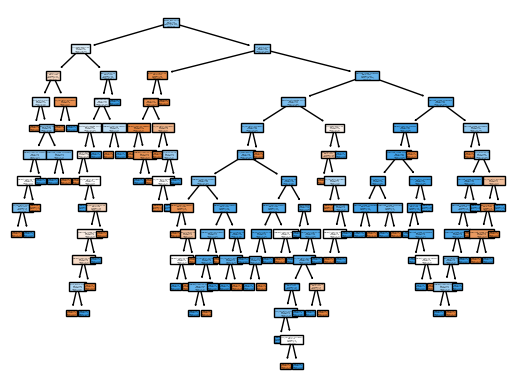

In [60]:
# Fit a random forest model to the data
rf = RandomForestClassifier(n_estimators=100, criterion='gini').fit(X_train, y_train)

# Plot the first decision tree in the forest
plot_tree(rf.estimators_[0], feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True)

In [74]:
# Predict & get results for X_test
y_pred_rf = rf.predict(X_test)

print("C5.0 MODEL:")
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = rf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

C5.0 MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            23            23     46
Actual: 1             5            99    104
Total                28           122    150

Accuracy: 0.813
Sensitivity (Recall): 0.952
Specificity: 0.500
AUC score: 0.7931647157190634


### Naive Bayes

In [86]:
# Flatted y_train into 1d array & fit NB model
y_train_1d = np.array(y_train).reshape(-1, 1)
nb = MultinomialNB().fit(X_train, y_train_1d)

# Predict & get results for X_test
y_pred_nb = nb.predict(X_test)

/Users/shailjasomani/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [87]:
print("NAIVE BAYES MODEL:")
cm = confusion_matrix(y_test, y_pred_nb)
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = nb.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

NAIVE BAYES MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            16            30     46
Actual: 1            26            78    104
Total                42           108    150

Accuracy: 0.627
Sensitivity (Recall): 0.750
Specificity: 0.348
AUC score: 0.5495401337792643


### Neural Network